We will use a Dirichlet process to estimate the density of waiting times between eruptions of the Old Faithful geyser in Yellowstone National Park.

In [1]:
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import pymc3 as pm
import seaborn as sns
import pandas as pd
import theano.tensor as T
import scipy.stats as stats

C:\Users\adam\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [16]:
from statsmodels.datasets import get_rdataset
old_faithful_df = get_rdataset('faithful', cache=True).data[['waiting']]

In [17]:
df = pd.DataFrame(old_faithful_df)
df.columns = ['t_btw_eruptions']
df = df.t_btw_eruptions

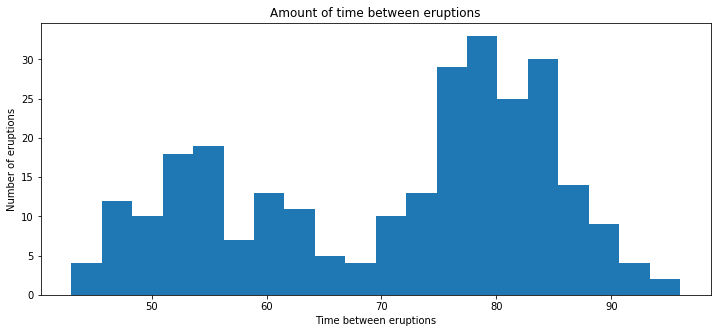

In [18]:
plt.figure(figsize=(12,5))
plt.hist(df, bins=20)
plt.title("Amount of time between eruptions")
plt.ylabel("Number of eruptions")
plt.xlabel("Time between eruptions")
plt.show()

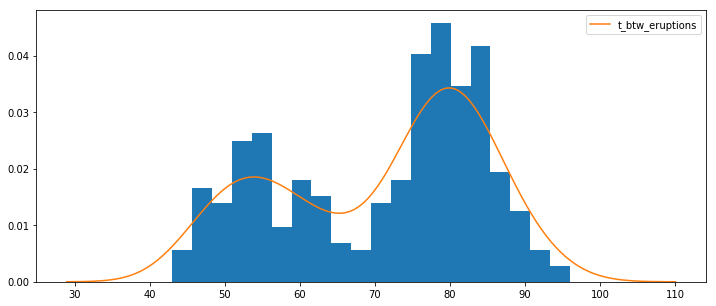

In [19]:
plt.figure(figsize=(12,5))
plt.hist(df, bins=20,normed=True)
sns.kdeplot(df)
plt.show()

It appears that we are dealing with two normal distributions.
* 65 minutes seems to be the cutoff point; let's use that to visualize the two clusters/distributions

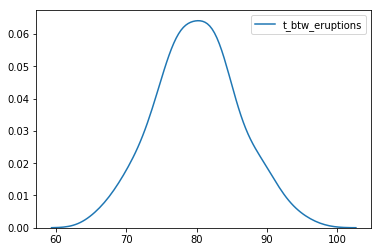

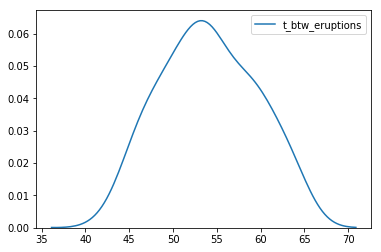

In [59]:
sns.kdeplot(df[df>65])
plt.show()
sns.kdeplot(df[df<65])
plt.show()

Indeed, they appear to have the shape of a normal distribution
* Therefore, we shall use the Dirichlet process as part of an unsupervised clustering of this Gaussian Mixture model 

In [21]:
print("The approximate standard deviation: "+str(df[df<68].std()))
print("The approximate standard deviation: "+str(df[df>68].std()))
print("The approximate mean: "+str(df[df<68].mean()))
print("The approximate mean: "+str(df[df>68].mean()))

The approximate standard deviation: 5.895341423959303
The approximate standard deviation: 5.564192117291482
The approximate mean: 54.75
The approximate mean: 80.35672514619883


**Building our model**

In [61]:
with pm.Model() as model:
    w = pm.Dirichlet('w', a=np.array([1,1])) # only two 1's because we are assuming there are 2 Gaussian distributions

    mu = pm.Normal('mu', 50, 100, shape=2)   #the hyperparameters should be pretty inclusive of the potential means
    sd = pm.Uniform('sd', 5, 40, shape=2)

    data_obs = pm.NormalMixture('data_obs', w, mu, sd=sd, observed=df)

Visualizing our parameters with the chosen hyperparameters

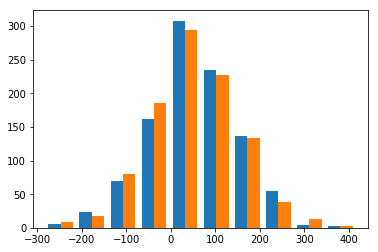

With these parameters, the mean can fall anywhere form -100 to 150. Given that the true means are around 50 and 80, we are providing MCMC an adequate surface space to find the true parameters


In [23]:
plt.hist(pm.Normal.dist(50,100,shape=2).random(size=1000))
plt.show()
print("With these parameters, the mean can fall anywhere form -100 to 150. Given that the true means are \
around 50 and 80, we are providing MCMC an adequate surface space to find the true parameters")

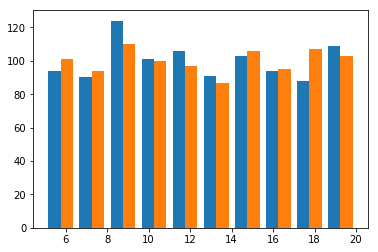

Given that the true standard deviation are around 5-6, this is also an adequate space for MCMC to search in.


In [24]:
plt.hist(pm.Uniform.dist(5, 20, shape=2).random(size=1000))
plt.show()
print("Given that the true standard deviation are around 5-6, this is also an adequate space for MCMC to search in.")

In [62]:
with model:
    trace = pm.sample(10000, tune=5000, njobs=1)[2000:]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd_interval__, mu, w_stickbreaking__]
100%|███████████████████████████████████████████████████████████████████████████| 15000/15000 [00:47<00:00, 319.01it/s]


In [63]:
pm.summary(trace, varnames=['w', 'mu','sd'])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
w__0,0.361580,0.031483,0.000287,0.300612,0.423720,11088.972680,1.000104
w__1,0.638420,0.031483,0.000287,0.576280,0.699388,11088.972680,1.000104
mu__0,54.636692,0.733737,0.006197,53.169282,56.024163,10702.917670,1.000048
mu__1,80.083375,0.526424,0.005004,79.001496,81.067227,10809.290072,0.999967
sd__0,6.041785,0.555824,0.006185,5.005338,7.071807,9029.801752,0.999944
sd__1,5.949742,0.411096,0.003719,5.181366,6.748304,11780.519565,0.999941


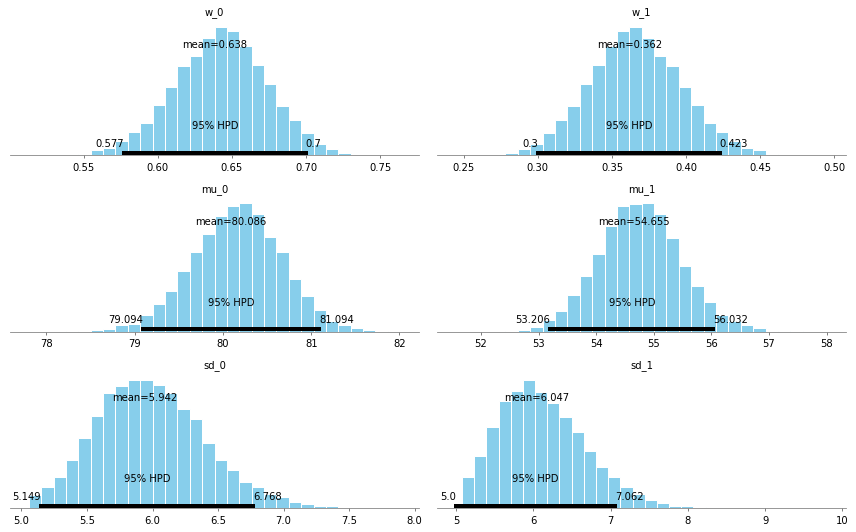

In [44]:
pm.plot_posterior(trace, varnames=['w', 'mu','sd'], color='#87ceeb');

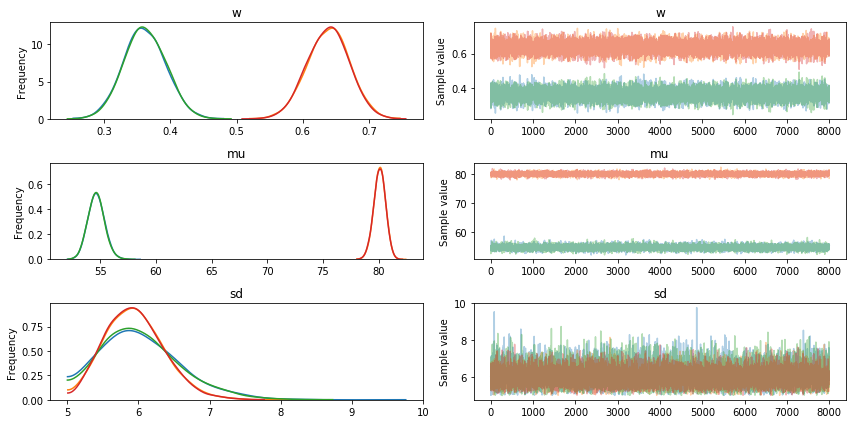

In [64]:
pm.traceplot(trace, varnames=['w', 'mu','sd']);

# Visualizing traced parameters on original data

In [65]:
"""
This sample_ppc function will randomly draw 500 samples of parameters from the trace. Then, for each sample, 
it will draw 100 random numbers from a normal distribution specified by the values 
of mu and std in that sample.
"""

with model:
    ppc_trace = pm.sample_ppc(trace, 5000, random_seed=13)

100%|████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:03<00:00, 1300.86it/s]


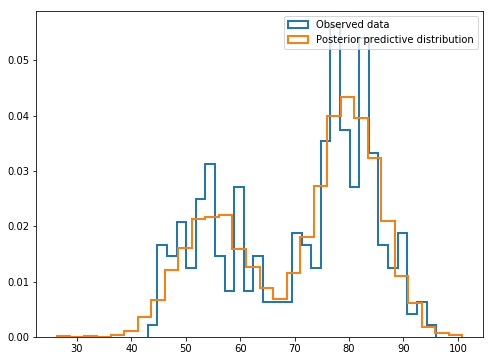

In [69]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.hist(df, bins=30, normed=True,
        histtype='step', lw=2,
        label='Observed data');
ax.hist(ppc_trace['data_obs'], bins=30, normed=True,
        histtype='step', lw=2,
        label='Posterior predictive distribution');

ax.legend(loc=1);

#  Predictive analysis to determine the cluster probability of each value

**To predict the probability of value x (waiting times between eruptions of the Old Faithful geyser) belonging to cluster 0 or cluster 1, we need to analyze the common area within the two normal distributions.**

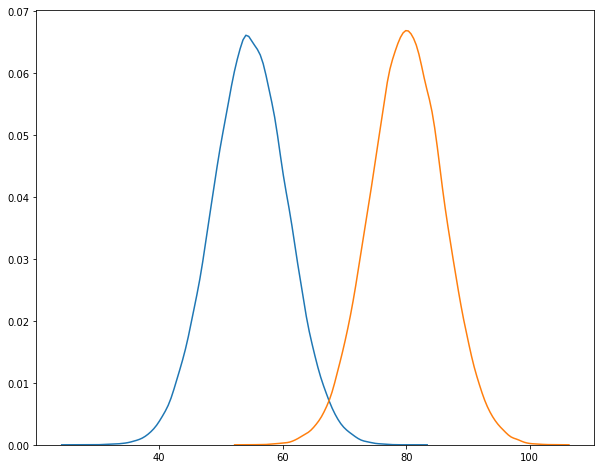

In [260]:
np.random.seed(seed=13)
plt.figure(figsize=(10,8))
cluster_0 = pm.Normal.dist(mu=trace['mu'][:,0].mean(), sd=trace['sd'][:,0].mean()).random(size=100000)
cluster_1 = pm.Normal.dist(mu=trace['mu'][:,1].mean(), sd=trace['sd'][:,1].mean()).random(size=100000)

sns.kdeplot(cluster_0)
sns.kdeplot(cluster_1)

# plt.xlim(66,69)
plt.show()

Suppose we observe a new data point, say `x=69`, and we wish to calculate the probability of it being assigned to  cluster 1. Let's denote the assignment of x as Lx, which is equal to 0 or 1. We are interested in P(Lx=1|x=69).

According to Bayes theorem:
$$P(A\mid B) = \frac{P(B\mid A)P(A)}{P(B)}$$

In our case, A represents Lx=1 and B is the evidence we have: we observe that x=69. 

we are interested in asking "Is the probability that x is in cluster 1 greater than the probability it is in cluster 0?", where the probability is dependent on the chosen parameters:
$$P(L_x=1\mid x=69) > P(L_x=0\mid x=69)$$

Which translates to:
$$\frac{P(x=69\mid L_x=1)P(L_x=1)}{P(x=69)} > \frac{P(x=69\mid L_x=0)P(L_x=0)}{P(x=69)}$$

As the denominators are equal, they can be ignored, so our formula is:

$${P(x=69\mid L_x=1)P(L_x=1)} > {P(x=69\mid L_x=0)P(L_x=0)}$$

P(Lx=0) is equal to:

In [186]:
trace['w'][:,0]

array([0.37357286, 0.4159538 , 0.2795939 , ..., 0.37985725, 0.37985725,
       0.34872186])

In [242]:
norm_pdf = stats.norm.pdf

prob_cluster_0 = trace['w'][:,0] # P(Lx=0)
prob_cluster_1 =  1 - prob_cluster_0

x=69

v = norm_pdf(x, loc=trace['mu'][:,1], scale=trace['sd'][:,1]) * (prob_cluster_1) > \
    norm_pdf(x, loc=trace['mu'][:,0], scale=trace['sd'][:,0]) * (prob_cluster_0)
    
print("Probability of belonging to cluster one (where mean is about 80) : "+str(v.mean()))

Probability of belonging to cluster one (where mean is about 80) : 0.98875


In [239]:
wait_times = []
def wait_time_bw_eruption (*args):
    for x in args:
        v = norm_pdf(x, loc=trace['mu'][:,1], scale=trace['sd'][:,1]) * (prob_cluster_1) > \
            norm_pdf(x, loc=trace['mu'][:,0], scale=trace['sd'][:,0]) * (prob_cluster_0)
        wait_times.append(v.mean())
    return (wait_times)

wait_time_bw_eruption(68, 67, 66.62, 66.5, 66, 65)
print("")

[0.9123125, 0.6464375, 0.504375, 0.4595625, 0.2730625, 0.0578125]